In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os

# Initial FASERvSi studies

Detector setup:
132 layers of Tungsten and 'SCT' (sensitive vacuum)
Tungsten layers are 0.9 mm thick
Gap between Tungsten sheets is 0.5 mm
1000 events generated - mix of $\nu_e$, $\nu_\mu$ and $\nu_\tau$

Real gap *should* be 7.08 mm but there seems to be an issue with the GENIE code which is preventing neutrinos from being generated in that setup

In [14]:
data = uproot.open("../FASERvSi_baseline-build/output.root")

In [37]:
def get_pos_and_energy(uproot_data, particle_type, event_number=None):
    allowed_types = ["ep", "em", "mm",  "mp", "hm", "hp"]
    if particle_type not in allowed_types:
        raise ValueError(f"particle_type must be one of these {allowed_types}")

    kin_suffixes = ["x", "y", "z", "E"]
    
    cut_expression = f"{particle_type}_z > 0" 
    
    kinematics = uproot_data.arrays([f"{particle_type}_{k}" for k in kin_suffixes], library="np", cut=cut_expression)
    
    if event_number is None:
        return {"x": kinematics[f"{particle_type}_x"], "y": kinematics[f"{particle_type}_y"], "z": kinematics[f"{particle_type}_z"], "E": kinematics[f"{particle_type}_E"]}
    
    return {"x": kinematics[f"{particle_type}_x"][event_number], "y": kinematics[f"{particle_type}_y"][event_number], "z": kinematics[f"{particle_type}_z"][event_number], "E": kinematics[f"{particle_type}_E"][event_number]}
    

In [38]:
hits = [data[treename] for treename in data.keys()]

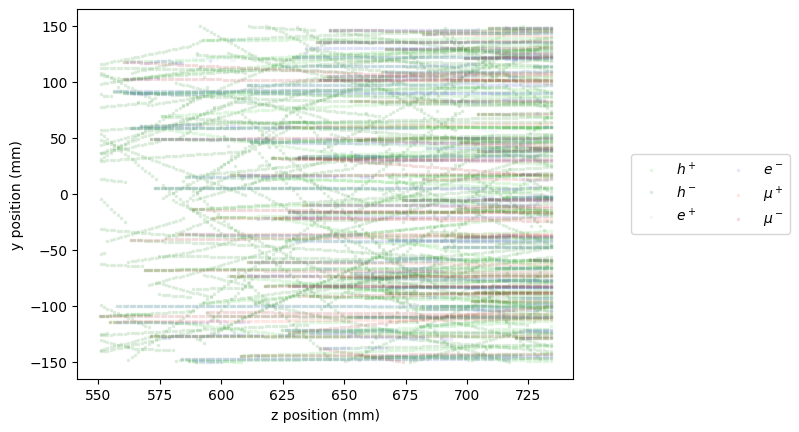

In [39]:
fig, ax = plt.subplots()

for station in hits:
    eplus_kin = get_pos_and_energy(station, "ep")   # Electrons
    eminus_kin = get_pos_and_energy(station, "em")
    
    mplus_kin = get_pos_and_energy(station, "mp")   # Muons
    mminus_kin = get_pos_and_energy(station, "mm") 
    
    hplus_kin = get_pos_and_energy(station, "hp")   # Hadrons
    hminus_kin = get_pos_and_energy(station, "hm")
    
    marker_size = 1
    alpha = 0.1
    
    ax.scatter(hplus_kin["z"], hplus_kin["y"], color='limegreen', marker=",", label=r"$h^+$", alpha=alpha, s=marker_size)
    ax.scatter(hminus_kin["z"], hminus_kin["y"], color='forestgreen', marker=",", label=r"$h^-$", alpha=alpha, s=marker_size)
    
    ax.scatter(eplus_kin["z"], eplus_kin["y"], color='lightblue', marker=",", label=r"$e^+$", alpha=alpha, s=marker_size)
    ax.scatter(eminus_kin["z"], eminus_kin["y"], color='mediumslateblue', marker=",", label=r"$e^-$", alpha=alpha, s=marker_size)
    
    ax.scatter(mplus_kin["z"], mplus_kin["y"], color='tomato', marker=",", label=r"$\mu^+$", alpha=alpha, s=marker_size)
    ax.scatter(mminus_kin["z"], mminus_kin["y"], color='firebrick', marker=",", label=r"$\mu^-$", alpha=alpha, s=marker_size)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
ax.set_xlabel("z position (mm)")
ax.set_ylabel("y position (mm)")
plt.savefig("FASERvSi-0.5mmSCT-particle-dist-z-y.pdf")

In [43]:

os.makedirs("eventPlots/FASERvSi-0.5mmSCT", exist_ok=True)

from tqdm import tqdm

max_events = 50

for i, event in tqdm(enumerate(uproot.iterate("../FASERvSi_baseline-build/output.root", step_size=1)), total=50):
    
    hits = [event[treename] for treename in event.keys()]
    
    fig, ax = plt.subplots()
    for station_number, station in enumerate(hits):
        
        marker_size = 1
        alpha = 1
        
        try:        
            hplus_kin = get_pos_and_energy(station, "hp", i)   # Hadrons
            ax.scatter(hplus_kin["z"], hplus_kin["y"], color='limegreen', marker=",", label=r"$h^+$", alpha=alpha, s=marker_size)
        except IndexError:
            pass
        
        try:
            hminus_kin = get_pos_and_energy(station, "hm", i)
            ax.scatter(hminus_kin["z"], hminus_kin["y"], color='forestgreen', marker=",", label=r"$h^-$", alpha=alpha, s=marker_size)
        except IndexError:
            pass
        
        try:
            eplus_kin = get_pos_and_energy(station, "ep", i)   # Electrons
            ax.scatter(eplus_kin["z"], eplus_kin["y"], color='lightblue', marker=",", label=r"$e^+$", alpha=alpha, s=marker_size)
        except IndexError:
            pass
        
        try:
            ax.scatter(eminus_kin["z"], eminus_kin["y"], color='mediumslateblue', marker=",", label=r"$e^-$", alpha=alpha, s=marker_size)
            eminus_kin = get_pos_and_energy(station, "em", i)
        except IndexError:
            pass
        
        try:
            mplus_kin = get_pos_and_energy(station, "mp", i)   # Muons
            ax.scatter(mplus_kin["z"], mplus_kin["y"], color='tomato', marker=",", label=r"$\mu^+$", alpha=alpha, s=marker_size)
        except IndexError:
            pass
        
        try:
            ax.scatter(mminus_kin["z"], mminus_kin["y"], color='firebrick', marker=",", label=r"$\mu^-$", alpha=alpha, s=marker_size)
            mminus_kin = get_pos_and_energy(station, "mm", i) 
        except IndexError:
            pass

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncols=2, loc='center right', bbox_to_anchor=(1.45, 0.5))
    ax.set_xlabel("z position (mm)")
    ax.set_ylabel("y position (mm)")
    ax.set_xlim((550, 735))
    ax.set_xlim((-150, 150))
    plt.savefig(f"eventPlots/FASERvSi-0.5mmSCT/event_{i}_particle-dist-z-y.png", dpi=300)
    plt.close()

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: TTree object paths must be specified in the 'files' as {"filenames*.root": "path"} if any files have more than one TTree

    TTrees: 'Hits1', 'Hits2', 'Hits3', 'Hits4', 'Hits5', 'Hits6', 'Hits7', 'Hits8', 'Hits9', 'Hits10', 'Hits11', 'Hits12', 'Hits13', 'Hits14', 'Hits15', 'Hits16', 'Hits17', 'Hits18', 'Hits19', 'Hits20', 'Hits21', 'Hits22', 'Hits23', 'Hits24', 'Hits25', 'Hits26', 'Hits27', 'Hits28', 'Hits29', 'Hits30', 'Hits31', 'Hits32', 'Hits33', 'Hits34', 'Hits35', 'Hits36', 'Hits37', 'Hits38', 'Hits39', 'Hits40', 'Hits41', 'Hits42', 'Hits43', 'Hits44', 'Hits45', 'Hits46', 'Hits47', 'Hits48', 'Hits49', 'Hits50', 'Hits51', 'Hits52', 'Hits53', 'Hits54', 'Hits55', 'Hits56', 'Hits57', 'Hits58', 'Hits59', 'Hits60', 'Hits61', 'Hits62', 'Hits63', 'Hits64', 'Hits65', 'Hits66', 'Hits67', 'Hits68', 'Hits69', 'Hits70', 'Hits71', 'Hits72', 'Hits73', 'Hits74', 'Hits75', 'Hits76', 'Hits77', 'Hits78', 'Hits79', 'Hits80', 'Hits81', 'Hits82', 'Hits83', 'Hits84', 'Hits85', 'Hits86', 'Hits87', 'Hits88', 'Hits89', 'Hits90', 'Hits91', 'Hits92', 'Hits93', 'Hits94', 'Hits95', 'Hits96', 'Hits97', 'Hits98', 'Hits99', 'Hits100', 'Hits101', 'Hits102', 'Hits103', 'Hits104', 'Hits105', 'Hits106', 'Hits107', 'Hits108', 'Hits109', 'Hits110', 'Hits111', 'Hits112', 'Hits113', 'Hits114', 'Hits115', 'Hits116', 'Hits117', 'Hits118', 'Hits119', 'Hits120', 'Hits121', 'Hits122', 'Hits123', 'Hits124', 'Hits125', 'Hits126', 'Hits127', 'Hits128', 'Hits129', 'Hits130', 'Hits131', 'Hits132'

in file ../FASERvSi_baseline-build/output.root